In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy
import tensorflow as tf
from tensorflow.keras.layers import Reshape, Multiply
import cv2
import numpy as np

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mariaherrerot/aptos2019")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'aptos2019' dataset.
Path to dataset files: /kaggle/input/aptos2019


In [3]:
unbalanced_data_path = path+'/train_images/train_images'

In [4]:
y_true = pd.read_csv(path+'/train_1.csv')
y_true['id_code'] = y_true['id_code'].map(lambda x: x + '.png' if not x.endswith('.png') else x)
y_true.head()

,id_code,diagnosis
0,1ae8c165fd53.png,2
1,1b329a127307.png,1
2,1b32e1d775ea.png,4
3,1b3647865779.png,0
4,1b398c0494d1.png,0


In [5]:
y_true['diagnosis']=y_true['diagnosis'].astype(str)
y_true.head()

,id_code,diagnosis
0,1ae8c165fd53.png,2
1,1b329a127307.png,1
2,1b32e1d775ea.png,4
3,1b3647865779.png,0
4,1b398c0494d1.png,0


In [ ]:
def image_resize(image):
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image=cv2.resize(image,(255,255))
  image=image/255.0
  return image

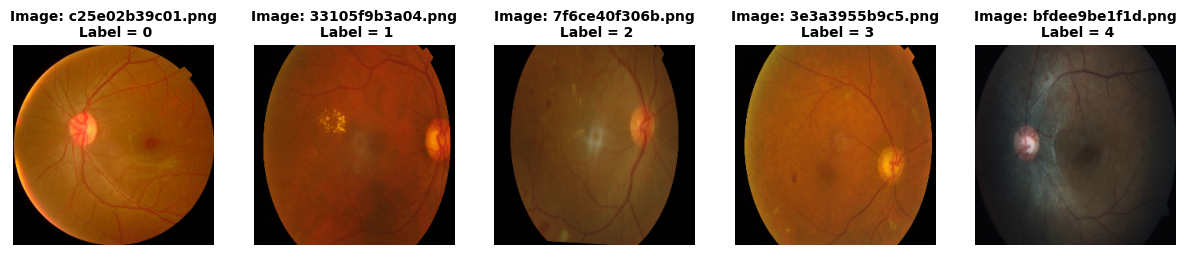

In [ ]:
train_df = pd.read_csv(path+'/train_1.csv')
train_df['id_code'] = train_df['id_code'].map(lambda x: x + '.png' if not x.endswith('.png') else x)


fig, ax = plt.subplots(1, 5, figsize=(15, 6))
for i in range(5):
    sample = train_df[train_df['diagnosis'] == i].sample(1)
    image_name = sample['id_code'].item()
    X = image_resize(cv2.imread(f"{unbalanced_data_path}/{image_name}"))
    ax[i].set_title(f"Image: {image_name}\n Label = {sample['diagnosis'].item()}",
                    weight='bold', fontsize=10)
    ax[i].axis('off')
    ax[i].imshow(X);

In [ ]:
train_df['diagnosis']=train_df['diagnosis'].astype(str)

train_datagen = ImageDataGenerator(validation_split=0.10,
                                   preprocessing_function=image_resize)


train_gen = train_datagen.flow_from_dataframe(train_df,
                                                    x_col='id_code',
                                                    y_col='diagnosis',
                                                    directory = unbalanced_data_path,
                                                    target_size=(255,255),
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    subset='training')

val_gen = train_datagen.flow_from_dataframe(train_df,
                                                  x_col='id_code',
                                                  y_col='diagnosis',
                                                  directory = unbalanced_data_path,
                                                  target_size=(255,255),
                                                  batch_size=32,
                                                  class_mode='categorical',
                                                  subset='validation')

Found 2637 validated image filenames belonging to 5 classes.
Found 293 validated image filenames belonging to 5 classes.


In [ ]:
classes = np.unique(train_df['diagnosis'])
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_df['diagnosis'])
class_weight_dict = dict(zip(classes, class_weights))

print("Calculated Class Weights:", class_weight_dict)

Calculated Class Weights: {'0': np.float64(0.4086471408647141), '1': np.float64(1.9533333333333334), '2': np.float64(0.7252475247524752), '3': np.float64(3.8051948051948052), '4': np.float64(2.5042735042735043)}


## Load Pre-trained InceptionV3 Model



In [ ]:
from tensorflow.keras.applications import InceptionV3

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(255, 255, 3))
print("Pre-trained InceptionV3 model loaded successfully.")

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Pre-trained InceptionV3 model loaded successfully.


## Modify Model for Transfer Learning



In [ ]:
for layer in base_model.layers:
    layer.trainable = False

inputs = Input(shape=(255, 255, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
outputs = Dense(5, activation='softmax')(x)

model = Model(inputs, outputs)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 255, 255, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 6, 6, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_94          │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_95          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,337,829 (85.21 MB)

 Trainable params: 530,437 (2.02 MB)

 Non-trainable params: 21,807,392 (83.19 MB)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Implement Grad-CAM Function



In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):

    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)


    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))


    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)


    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

print("Grad-CAM function 'make_gradcam_heatmap' defined.")

Grad-CAM function 'make_gradcam_heatmap' defined.


## Train the Model



In [ ]:
def lr_schedule_exp(epoch):
  if epoch<4:
    return float(tf.exp(-epoch/10.)*0.01)/2
  elif epoch<8:
    return float(tf.exp(-epoch/10.)*0.01)/3
  else:
    return float(tf.exp(-epoch/10.)*0.01)/4


schedule_4=tf.keras.callbacks.LearningRateScheduler(lr_schedule_exp)
check_point_4=tf.keras.callbacks.ModelCheckpoint('model_4_best.keras',monitor='val_accuracy',verbose=1,save_best_only=True,mode='max')
early_stop=tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=3,verbose=1,restore_best_weights=True,mode='max')

In [ ]:
history = model.fit(train_gen,
                    epochs=10,
                    validation_data=val_gen,
                    class_weight=class_weight_dict,callbacks=[schedule_4,check_point_4,early_stop])

Epoch 1/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8191 - loss: 0.5444
Epoch 1: val_accuracy improved from -inf to 0.72355, saving model to model_4_best.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 313s 4s/step - accuracy: 0.8187 - loss: 0.5457 - val_accuracy: 0.7235 - val_loss: 0.7152 - learning_rate: 0.0050
Epoch 2/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8730 - loss: 0.3414
Epoch 2: val_accuracy improved from 0.72355 to 0.75768, saving model to model_4_best.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 292s 4s/step - accuracy: 0.8730 - loss: 0.3416 - val_accuracy: 0.7577 - val_loss: 0.7783 - learning_rate: 0.0045
Epoch 3/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9323 - loss: 0.2057
Epoch 3: val_accuracy improved from 0.75768 to 0.76792, saving model to model_4_best.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 291s 4s/step - accuracy: 0.9322 - loss: 0.2057 - val_accuracy: 0.7679 - val_loss: 0.7389 - learning_rate: 0.0041
Epoch 4/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 

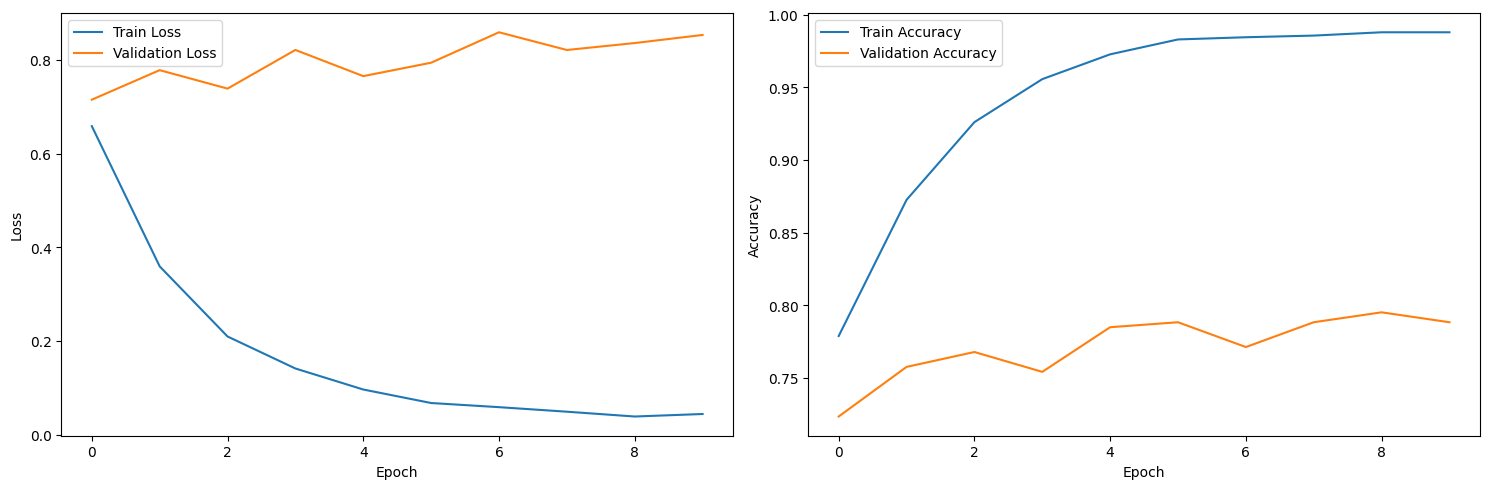

In [ ]:
fig,axes=plt.subplots(1,2,figsize=(15,5))

axes[0].plot(history.history['loss'],label='Train Loss')
axes[0].plot(history.history['val_loss'],label='Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].plot(history.history['accuracy'],label='Train Accuracy')
axes[1].plot(history.history['val_accuracy'],label='Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()

In [ ]:
predictions=model.predict(val_gen)
predictions=np.argmax(predictions,axis=1)

10/10 ━━━━━━━━━━━━━━━━━━━━ 44s 4s/step


<Axes: >

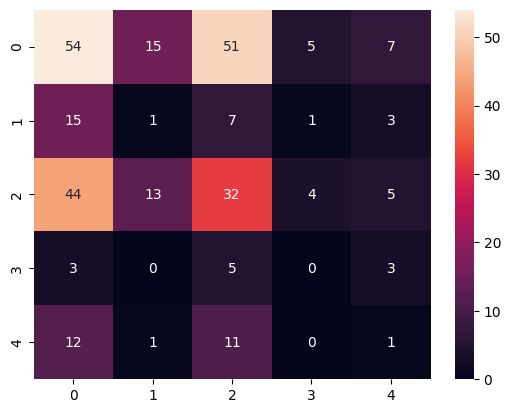

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
sns.heatmap(confusion_matrix(val_gen.classes,predictions),annot=True,fmt='d')

In [ ]:
print(classification_report(val_gen.classes,predictions))

              precision    recall  f1-score   support

           0       0.42      0.41      0.42       132
           1       0.03      0.04      0.04        27
           2       0.30      0.33      0.31        98
           3       0.00      0.00      0.00        11
           4       0.05      0.04      0.05        25

    accuracy                           0.30       293
   macro avg       0.16      0.16      0.16       293
weighted avg       0.30      0.30      0.30       293



In [ ]:
selected_images_for_heatmap = []
unique_diagnoses = train_df['diagnosis'].unique()

for diagnosis_label in sorted(unique_diagnoses):
    sample_image = train_df[train_df['diagnosis'] == diagnosis_label].sample(1)
    selected_images_for_heatmap.append({
        'id_code': sample_image['id_code'].item(),
        'diagnosis': sample_image['diagnosis'].item()
    })

selected_images_df = pd.DataFrame(selected_images_for_heatmap)
print("Selected images for heatmap generation:")
print(selected_images_df)

Selected images for heatmap generation:
            id_code diagnosis
0  33b91def2035.png         0
1  7b20210d9120.png         1
2  2bd4d4fbed5c.png         2
3  bb7e0a2544cd.png         3
4  6630f8675a97.png         4


# InceptionV3 With Prepocesing

In [6]:
import cv2
import numpy as np

def apply_clahe(image):

    if image.dtype != np.uint8:

        if image.max() <= 1.0 and image.min() >= 0.0:
            image = (image * 255).astype(np.uint8)
        else:

            image = image.astype(np.uint8)


    if len(image.shape) == 3 and image.shape[2] == 3:
        lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)

        l_channel, a_channel, b_channel = cv2.split(lab)

        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        cl = clahe.apply(l_channel)

        limg = cv2.merge((cl, a_channel, b_channel))

        enhanced_image = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
    elif len(image.shape) == 2:
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        enhanced_image = clahe.apply(image)
    else:
        raise ValueError("Unsupported image format. Image must be grayscale or 3-channel color.")

    return enhanced_image

In [7]:
def crop_image_from_gray(img, tol=7):
    """
    Applies masks to the orignal image and
    returns the a preprocessed image with
    3 channels

    :param img: A NumPy Array that will be cropped
    :param tol: The tolerance used for masking

    :return: A NumPy array containing the cropped image
    """



    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1),mask.any(0))]

    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol

        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0):
            return img
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)

        return img

def preprocess_image(image, sigmaX=10):
    """
    The whole preprocessing pipeline:
    1. Read in image
    2. Apply masks
    3. Resize image to desired size
    4. Add Gaussian noise to increase Robustness

    :param img: A NumPy Array that will be cropped
    :param sigmaX: Value used for add GaussianBlur to the image

    :return: A NumPy array containing the preprocessed image
    """
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (512,512))
    image = cv2.addWeighted (image,4, cv2.GaussianBlur(image, (0,0) ,sigmaX), -4, 128)
    return apply_clahe(image)


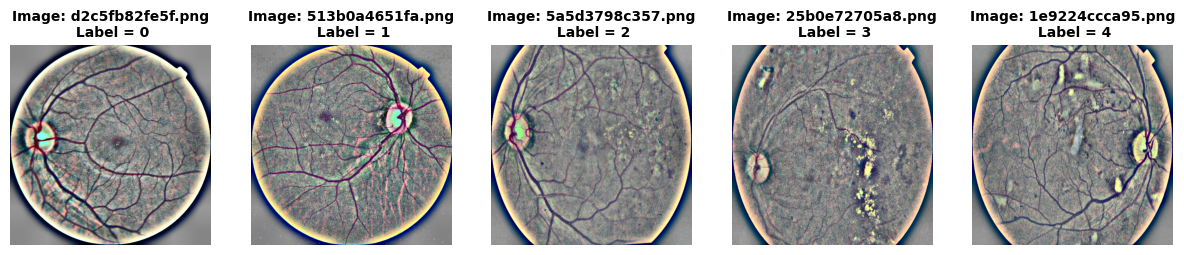

In [10]:
train_df = pd.read_csv(path+'/train_1.csv')
train_df['id_code'] = train_df['id_code'].map(lambda x: x + '.png' if not x.endswith('.png') else x)


fig, ax = plt.subplots(1, 5, figsize=(15, 6))
for i in range(5):
    sample = train_df[train_df['diagnosis'] == i].sample(1)
    image_name = sample['id_code'].item()
    X = preprocess_image(cv2.imread(f"{unbalanced_data_path}/{image_name}"))
    ax[i].set_title(f"Image: {image_name}\n Label = {sample['diagnosis'].item()}",
                    weight='bold', fontsize=10)
    ax[i].axis('off')
    ax[i].imshow(X);

# Make The Dataset Balanced

In [11]:
def augmentation_layer():
    """Augmentation for balancing: flips, rotation, crop, zoom"""
    return tf.keras.Sequential(
        [
            tf.keras.layers.RandomFlip("horizontal"),
            tf.keras.layers.RandomFlip("vertical"),
            tf.keras.layers.RandomRotation(0.8, fill_mode="constant"),
            tf.keras.layers.RandomZoom(0.3),
        ]
    )



In [12]:
TARGET_IMAGES = 1500
input_dir = os.path.join(path,"train_images", "train_images")
output_dir = "/kaggle/working/augmented_train_images"
OUTPUT_CSV="/kaggle/working/augmented_labels.csv"
os.makedirs(output_dir, exist_ok=True)

df = pd.read_csv(os.path.join(path,"train_1.csv"))

labels_list=[]

# Instantiate the augmentation layer once
augmentation_model = augmentation_layer()

for cls in df['diagnosis'].unique():
    cls_df = df[df['diagnosis'] == cls]
    images = cls_df['id_code'].tolist()

    count = len(images)
    i = 0

    while count < TARGET_IMAGES:
        img_name = np.random.choice(images)
        img_path = os.path.join(input_dir, img_name + ".png")

        img = cv2.imread(img_path)

        if img is None:
            print(f"Warning: Could not load image {img_path}. Skipping augmentation for this image.")
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        img_tf = tf.convert_to_tensor(img, dtype=tf.float32)
        # Apply the augmentation model to the image tensor
        augmented_img_tf = augmentation_model(img_tf)
        img_tf = tf.cast(augmented_img_tf, tf.uint8).numpy()


        save_name = f"{img_name}_aug_{i}.png"
        labels_list.append([save_name,cls])
        cv2.imwrite(os.path.join(output_dir, save_name),
                    cv2.cvtColor(img_tf, cv2.COLOR_RGB2BGR))

        count += 1
        i += 1

    print(f"Class {cls} augmented to {TARGET_IMAGES} images.")

augmented_df = pd.DataFrame(labels_list, columns=["filename", "label"])
augmented_df.to_csv(OUTPUT_CSV, index=False)

print(f"\nSaved new labels to: {OUTPUT_CSV}")
print(f"Total augmented images: {len(augmented_df)}")
train_images_path = "/kaggle/working/augmented_train_images"
path_au_images="/kaggle/working/augmented_labels.csv"

Class 2 augmented to 1500 images.


KeyboardInterrupt: 

In [ ]:
train_df['diagnosis']=train_df['diagnosis'].astype(str)

train_datagen = ImageDataGenerator(validation_split=0.10,
                                   preprocessing_function=crop_image_from_gray)


train_gen = train_datagen.flow_from_dataframe(train_df,
                                                    x_col='id_code',
                                                    y_col='diagnosis',
                                                    directory = unbalanced_data_path,
                                                    target_size=(512,512),
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    subset='training')

val_gen = train_datagen.flow_from_dataframe(train_df,
                                                  x_col='id_code',
                                                  y_col='diagnosis',
                                                  directory = unbalanced_data_path,
                                                  target_size=(512,512),
                                                  batch_size=32,
                                                  class_mode='categorical',
                                                  subset='validation')

Found 2637 validated image filenames belonging to 5 classes.
Found 293 validated image filenames belonging to 5 classes.


In [ ]:
classes = np.unique(train_df['diagnosis'])
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_df['diagnosis'])
class_weight_dict = dict(zip(classes, class_weights))

print("Calculated Class Weights:", class_weight_dict)

Calculated Class Weights: {'0': np.float64(0.4086471408647141), '1': np.float64(1.9533333333333334), '2': np.float64(0.7252475247524752), '3': np.float64(3.8051948051948052), '4': np.float64(2.5042735042735043)}


In [ ]:
from tensorflow.keras.applications import InceptionV3

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(512, 512, 3))
print("Pre-trained InceptionV3 model loaded successfully.")

Pre-trained InceptionV3 model loaded successfully.


In [ ]:
x = base_model.output

ap = GlobalAveragePooling2D()(x)

attention_probs = Dense(64, activation='relu')(ap)

attention_probs = Dense(2048, activation='sigmoid')(attention_probs)

attention_probs = Reshape((1, 1, 2048))(attention_probs)

attended_output = Multiply()([x, attention_probs])

In [ ]:
x = GlobalAveragePooling2D()(attended_output)
x = Dense(250, activation='relu')(x)
output_layer = Dense(5, activation='softmax')(x)

In [ ]:
def lr_schedule_exp(epoch):
  if epoch<4:
    return float(tf.exp(-epoch/10.)*0.01)/2
  elif epoch<8:
    return float(tf.exp(-epoch/10.)*0.01)/3
  else:
    return float(tf.exp(-epoch/10.)*0.01)/4


schedule_4=tf.keras.callbacks.LearningRateScheduler(lr_schedule_exp)
check_point_4=tf.keras.callbacks.ModelCheckpoint('model_4_best.keras',monitor='val_accuracy',verbose=1,save_best_only=True,mode='max')
early_stop=tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=3,verbose=1,restore_best_weights=True,mode='max')

In [ ]:
model = Model(inputs=base_model.input, outputs=output_layer)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history_2 = model.fit(train_gen,
                    epochs=20,
                    validation_data=val_gen,
                    class_weight=class_weight_dict,callbacks=[schedule_4,check_point_4,early_stop])

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4621 - loss: 1.6984
Epoch 1: val_accuracy improved from -inf to 0.33447, saving model to model_4_best.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 452s 5s/step - accuracy: 0.4623 - loss: 1.6953 - val_accuracy: 0.3345 - val_loss: 586.0187 - learning_rate: 0.0050
Epoch 2/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4791 - loss: 1.2813
Epoch 2: val_accuracy improved from 0.33447 to 0.45051, saving model to model_4_best.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 350s 4s/step - accuracy: 0.4793 - loss: 1.2810 - val_accuracy: 0.4505 - val_loss: 326.8236 - learning_rate: 0.0045
Epoch 3/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5414 - loss: 1.1806
Epoch 3: val_accuracy improved from 0.45051 to 0.46416, saving model to model_4_best.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 346s 4s/step - accuracy: 0.5417 - loss: 1.1805 - val_accuracy: 0.4642 - val_loss: 182.5444 - learning_rate: 0.0041
Epoch 4/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accu

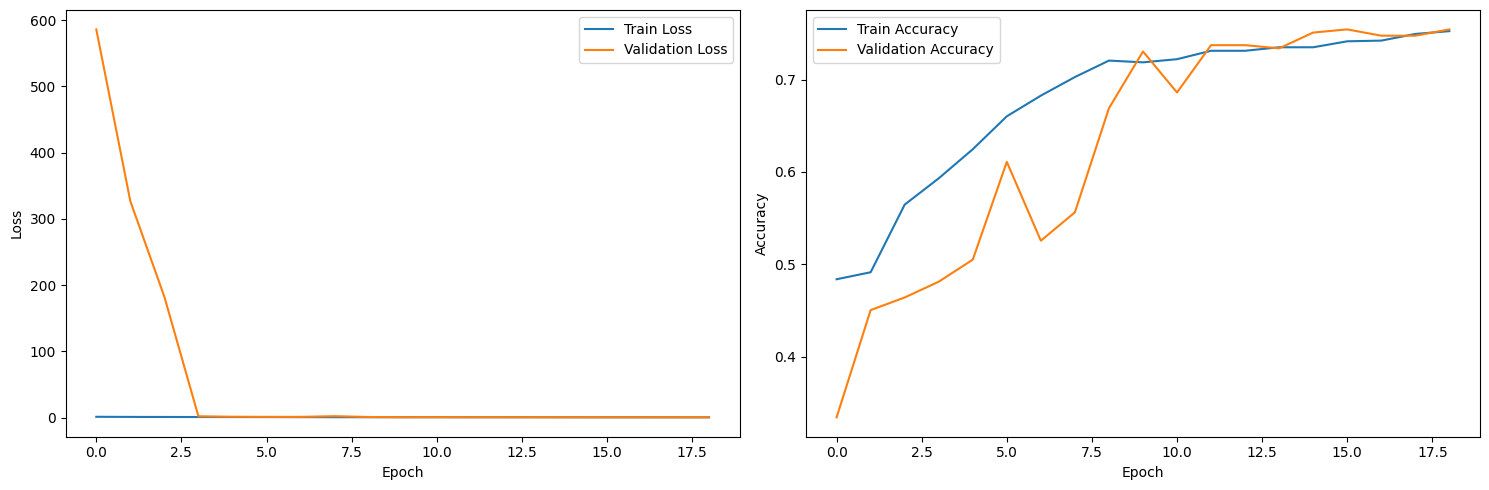

In [ ]:
fig,axes=plt.subplots(1,2,figsize=(15,5))

axes[0].plot(history_2.history['loss'],label='Train Loss')
axes[0].plot(history_2.history['val_loss'],label='Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].plot(history_2.history['accuracy'],label='Train Accuracy')
axes[1].plot(history_2.history['val_accuracy'],label='Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()

In [ ]:
images, labels = next(val_gen)
sample_image = images[0]
sample_label = labels[0]
sample_image_processed = np.expand_dims(sample_image, axis=0)

print(f"Sample image shape: {sample_image.shape}")
print(f"Sample image processed shape for model input: {sample_image_processed.shape}")
print(f"Sample label: {sample_label}")

Sample image shape: (255, 255, 3)
Sample image processed shape for model input: (1, 255, 255, 3)
Sample label: [0. 0. 1. 0. 0.]


In [ ]:
from scipy.ndimage import zoom
attention_model = Model(inputs=base_model.input, outputs=[attention_probs, output_layer])


attention_map_raw, predictions = attention_model.predict(sample_image_processed)

attention_output_model = Model(inputs=base_model.input, outputs=attended_output)
attended_feature_map = attention_output_model.predict(sample_image_processed)

attention_map = np.mean(attended_feature_map, axis=-1)
attention_map = attention_map[0]


scale_factor_h = sample_image.shape[0] / attention_map.shape[0]
scale_factor_w = sample_image.shape[1] / attention_map.shape[1]

attention_map_resized = zoom(attention_map, (scale_factor_h, scale_factor_w), order=1)

print(f"Raw attention map shape: {attention_map.shape}")
print(f"Resized attention map shape: {attention_map_resized.shape}")
print(f"Model prediction for sample image: {predictions}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
Raw attention map shape: (6, 6)
Resized attention map shape: (255, 255)
Model prediction for sample image: [[0.00884349 0.16364513 0.5506066  0.11003581 0.16686894]]


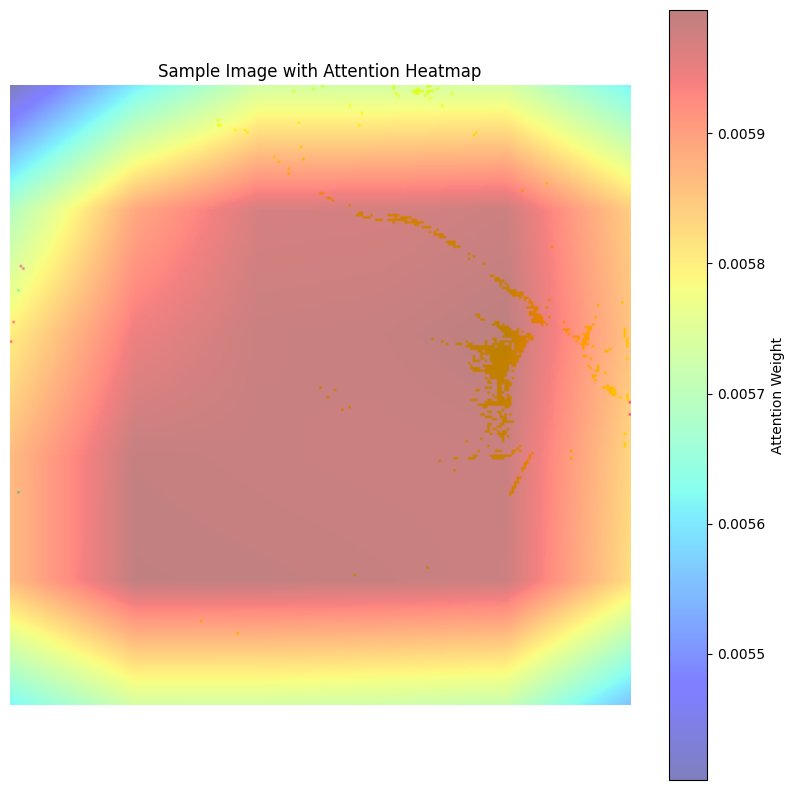

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 10))
plt.imshow(sample_image)
plt.imshow(attention_map_resized, cmap='jet', alpha=0.5)
plt.title('Sample Image with Attention Heatmap')
plt.axis('off')
plt.colorbar(label='Attention Weight')
plt.show()

# InceptionV4 With Balanced Data And Data Augmentation